In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pylab import rcParams
from crud import Connector
import statsmodels.tsa.stattools as st
import scipy.stats as stats
import matplotlib.pyplot as plt

In [36]:
rcParams['figure.figsize'] = 15, 6

In [37]:
connector = Connector()
prices = pd.DataFrame(connector.read_asset_closing_prices("Marfrig"), columns=['date', 'price'])
prices.set_index('date', inplace=True)

emotions = pd.DataFrame(connector.read_emotions_history("Marfrig"), columns=['date', 'emotion'])

In [38]:
emotions['emotion'] = emotions['emotion'].replace('very positive', 2)
emotions['emotion'] = emotions['emotion'].replace('positive', 1)
emotions['emotion'] = emotions['emotion'].replace('neutral', 0)
emotions['emotion'] = emotions['emotion'].replace('negative', -1)
emotions['emotion'] = emotions['emotion'].replace('very negative', -2)

C:\Users\gabri\AppData\Local\Temp\ipykernel_10624\1720431067.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emotions['emotion'] = emotions['emotion'].replace('very negative', -2)


In [39]:
for date in emotions['date'].unique():
    if emotions['date'].value_counts()[date] > 1:
        sum = 0
        counter = 0
        mean = 0
        auxiliar_dataframe = emotions.loc[emotions['date'] == date]
        
        for row in auxiliar_dataframe.iterrows():
            sum += row[1]['emotion']
            counter += 1
        
        mean = sum / counter

        aux = 0
        for row in emotions.iterrows():
            if row[1]['date'] == date:
                if aux != 0:
                    emotions.drop(row[0], inplace=True)
                else:
                    emotions.at[row[0], 'emotion'] = mean

                aux += 1

emotions.set_index(['date'], inplace=True)

In [40]:
def kpss_test(series):
    # Teste Statistic <= Critical value = stationary series 
    kpss = st.kpss(series)
    print('KPSS Test Statistic:', kpss[0])
    print('p-value:', kpss[1])
    print('Critical Values:')
    for key, item in kpss[3].items():
        print(f'   {key} : {item}')

    if kpss[0] < kpss[3]['5%']:
        print(f"The {series.name} series is stationary.")
    else:
        print(f"The {series.name} series is not stationary.")

In [41]:
kpss_test(prices['price'])
kpss_test(emotions['emotion'])

KPSS Test Statistic: 0.5382864123848856
p-value: 0.03304360081421495
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The price series is not stationary.
KPSS Test Statistic: 0.31582030402522454
p-value: 0.1
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The emotion series is stationary.


C:\Users\gabri\AppData\Local\Temp\ipykernel_10624\2030222486.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = st.kpss(series)


In [42]:
serie_diff = np.diff(prices['price'].astype(float))
serie_diff = pd.Series(serie_diff, index=prices.index[1:])
serie_diff.name = 'price_diff'

kpss_test(serie_diff)

KPSS Test Statistic: 0.07039411068628113
p-value: 0.1
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The price_diff series is stationary.


C:\Users\gabri\AppData\Local\Temp\ipykernel_10624\2030222486.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = st.kpss(series)


((array([-2.01197163, -1.6105163 , -1.36883603, -1.1880445 , -1.03948072,
         -0.91090285, -0.79586259, -0.69050407, -0.59231064, -0.49952733,
         -0.41086261, -0.32532036, -0.24209833, -0.16052274, -0.08000327,
          0.        ,  0.08000327,  0.16052274,  0.24209833,  0.32532036,
          0.41086261,  0.49952733,  0.59231064,  0.69050407,  0.79586259,
          0.91090285,  1.03948072,  1.1880445 ,  1.36883603,  1.6105163 ,
          2.01197163]),
  array([-2.42, -0.62, -0.4 , -0.35, -0.24, -0.09, -0.06,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.04,  0.06,  0.07,  0.12,  0.14,  0.14,  0.17,  0.19,  0.22,
          0.28,  0.6 ,  0.67,  0.76])),
 (np.float64(0.4242988551481455),
  np.float64(-0.023225806451612954),
  np.float64(0.7807651524707349)))

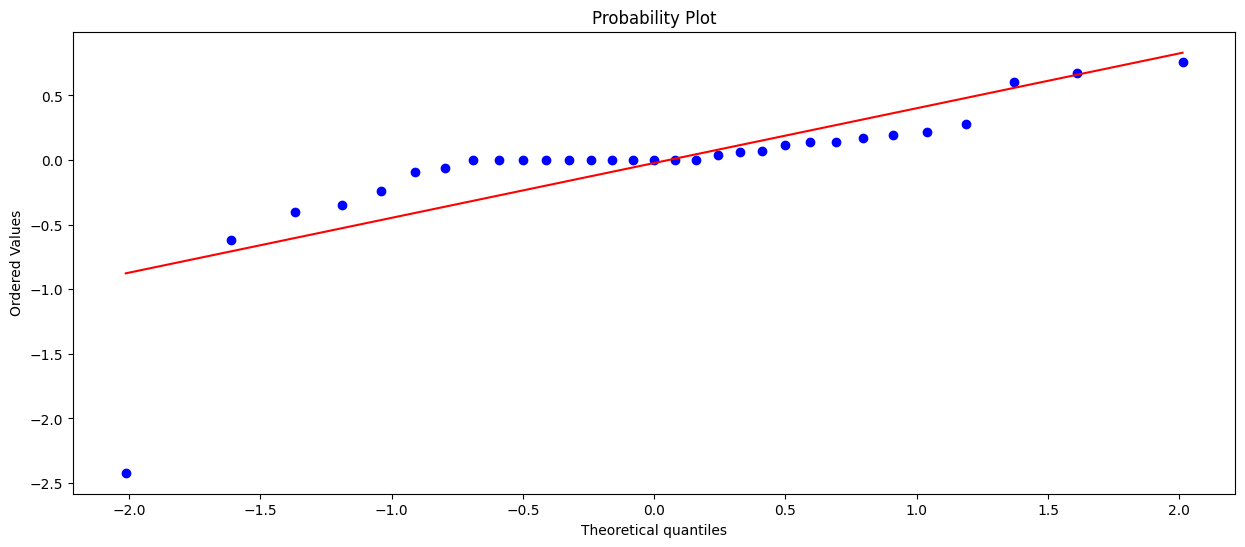

In [43]:
stats.probplot(serie_diff, dist="norm", plot=plt)

In [44]:
concatenated = pd.concat([serie_diff, emotions['emotion']], axis=1)
concatenated.columns = ['price_diff', 'emotion']
correlation = concatenated.corr()

<Axes: >

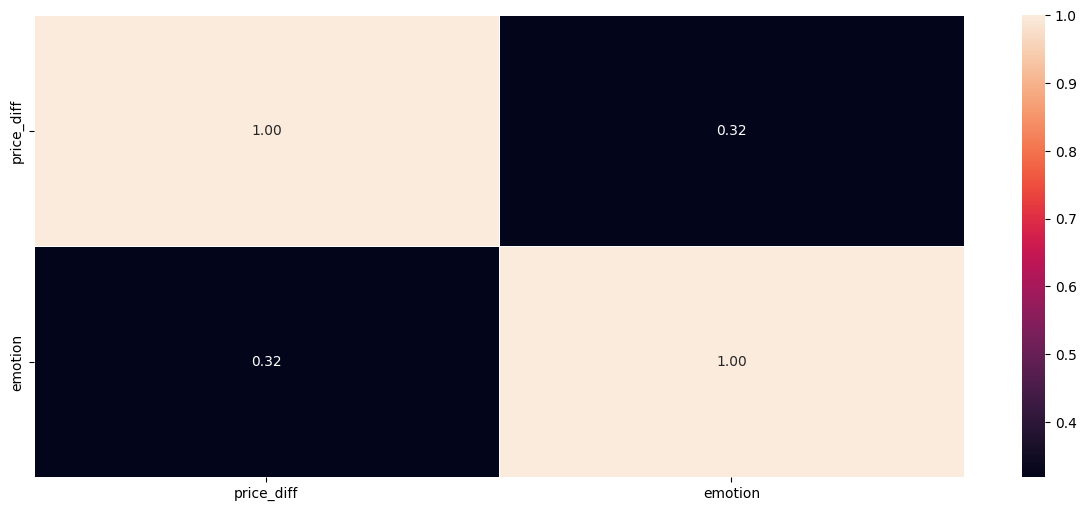

In [45]:
plot = sns.heatmap(correlation, annot = True, fmt=".2f", linewidths=.6)
plot

In [ ]:
# What if I shift the emotion series some days forward? Maybe the effect is delayed.

